<a href="https://colab.research.google.com/github/rabihchamas/Classifier-Aligner/blob/main/Copy_of_ClassifierAlignerNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:

import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Transformer
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [45]:
#The shuffeling method
import torch

def shuffleIm(tensor):
  for i in range(tensor.shape[0]):
    indexes = torch.randperm(tensor.shape[1])
    tensor[i] = tensor[i][indexes]
  return tensor  


In [48]:
# Define the architecture of the classifier
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='valid')
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        output = self.fc2(x)
        return output

In [49]:
class EmbedLayer(nn.Module):
    def __init__(self):
        super(EmbedLayer, self).__init__()
        self.cls_token = nn.Parameter(torch.zeros(1, 1, 6), requires_grad=True)  # Cls Token
        self.pos_embedding = nn.Parameter(torch.zeros(1, 129, 6), requires_grad=True)  # Positional Embedding

    def forward(self, x):
        x = x.reshape([x.shape[0], 6, -1])  # B E IH/P IW/P -> B E S
        x = x.transpose(1, 2)  # B E S -> B S E
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)
        x = x + self.pos_embedding
        return x

In [50]:
class AttentionLayer(nn.Module):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.n_attention_heads = 6
        self.embed_dim = 6
        self.head_embed_dim = self.embed_dim // self.n_attention_heads

        self.queries = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads, bias=True)
        self.keys = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads, bias=True)
        self.values = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads, bias=True)

        self.fc = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, q, k, v):

        x_queries = self.queries(q).reshape(q.shape[0], q.shape[1], self.n_attention_heads, self.head_embed_dim)  # B, Q, E -> B, Q, H, HE
        x_queries = x_queries.transpose(1, 2)  # B, Q, H, HE -> B, H, Q, HE
        x_keys = self.keys(k).reshape(k.shape[0], k.shape[1], self.n_attention_heads, self.head_embed_dim)  # B, K, E -> B, K, H, HE
        x_keys = x_keys.transpose(1, 2)  # B, K, H, HE -> B, H, K, HE
        x_values = self.values(v).reshape(v.shape[0], v.shape[1], self.n_attention_heads, self.head_embed_dim)  # B, V, E -> B, V, H, HE
        x_values = x_values.transpose(1, 2)  # B, V, H, HE -> B, H, V, HE

        x_queries = x_queries.reshape([-1, x_queries.shape[2], x_queries.shape[3]])  # B, H, Q, HE -> (BH), Q, HE
        x_keys = x_keys.reshape([-1, x_keys.shape[2], x_keys.shape[3]])  # B, H, K, HE -> (BH), K, HE
        x_values = x_values.reshape([-1, x_values.shape[2], x_values.shape[3]])  # B, H, V, HE -> (BH), V, HE

        x_keys = x_keys.transpose(1, 2)  # (BH), K, HE -> (BH), HE, K
        x_attention = x_queries.bmm(x_keys)  # (BH), Q, HE  .  (BH), HE, K -> (BH), Q, K
        x_attention = x_attention / (self.head_embed_dim ** 0.5)
        x_attention = torch.softmax(x_attention, dim=-1)

        x = x_attention.bmm(x_values)  # (BH), Q, K . (BH), V, HE -> (BH), Q, HE
        x = x.reshape([-1, self.n_attention_heads, x.shape[1], x.shape[2]])  # (BH), Q, HE -> B, H, Q, HE
        x = x.transpose(1, 2)  # B, H, Q, HE -> B, Q, H, HE
        x = x.reshape(x.shape[0], x.shape[1], -1)  # B, Q, H, HE -> B, Q, E
        return x

In [51]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.attention = AttentionLayer()
        self.fc1 = nn.Linear(6, 6*2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(6 * 2, 6)
        self.norm1 = nn.LayerNorm(6)
        self.norm2 = nn.LayerNorm(6)

    def forward(self, x):
        x_ = self.attention(x, x, x)
        x = x + x_
        x = self.norm1(x)
        x_ = self.fc1(x)
        x = self.activation(x)
        x_ = self.fc2(x_)
        x = x + x_
        x = self.norm2(x)

        return x

In [52]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()        
        self.fc1 = nn.Linear(129, 7*7*128)
        self.relu = nn.ReLU()
        self.conv_transpose1 = nn.ConvTranspose2d(6*128, 3*64, kernel_size=2, stride=2)
        self.conv_transpose2 = nn.ConvTranspose2d(3*64, 3, kernel_size=2, stride=2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        x = self.fc1(z)
        x = self.relu(x)
        x = x.view(-1,6* 128, 7, 7)
        x = self.conv_transpose1(x)
        x = self.relu(x)
        x = self.conv_transpose2(x)
        x = self.sigmoid(x)
        return x

In [53]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super(VisionTransformer, self).__init__()
        self.embedding = EmbedLayer()
        self.encoder = nn.Sequential(*[Encoder() for _ in range(1)], nn.LayerNorm(6))
        self.decoder = Decoder()

        # Intialization
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = x.transpose(1,2)
        x = self.decoder(x)
        return x

In [54]:
class CAN(nn.Module):
  def __init__(self):
    super(CAN,self).__init__()
    self.Classifier = Net()
    self.ImgEncoder = torch.nn.Sequential(torch.nn.Linear(28 * 28, 128),torch.nn.ReLU())
    self.Alighner = VisionTransformer()

  def forward(self,Im1,Im2,Im3):
    c1 = self.Classifier(Im1)
    c1=F.pad(c1,(63,64))
    c1=c1.reshape(Im1.shape[0],1,128)
    c2 = self.Classifier(Im2)
    c2=F.pad(c2,(63,64))
    c2=c2.reshape(Im1.shape[0],1,128)
    c3 = self.Classifier(Im3)
    c3=F.pad(c3,(63,64))
    c3=c3.reshape(Im1.shape[0],1,128)
    c = torch.cat((c1,c2,c3),1)
    Imgs = torch.cat((Im1,Im2,Im3),1)
    Imgs = Imgs.reshape(Im1.shape[0],Imgs.shape[1],-1)
    ShuffledImgs = shuffleIm(Imgs)
    ShuffledImgs = self.ImgEncoder(ShuffledImgs)
    input = torch.cat((c,ShuffledImgs),1)
    output = self.Alighner(input)
    return output

In [55]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
						train = True,
						download = True,
						transform = tensor_transform)


loader = torch.utils.data.DataLoader(dataset = dataset,
									batch_size = 64,
									shuffle = True)

In [56]:
# Model Initialization
model = CAN().cuda()

In [57]:



loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-3,
							weight_decay = 1e-8)


In [ ]:

# training loop
epochs = 100

for epoch in range(epochs):
    print("epoch number", epoch)
    c=0
    Imgs = []
    for (image, _) in loader:
      Imgs.append(image)
      c = c+1
      if(c==5):
        Img1 = Imgs[0].cuda()
        Img2 = Imgs[1].cuda()
        Img3 = Imgs[2].cuda()

        Imgss = torch.cat((Img1,Img2,Img3),1)

        pred = model(Img1,Img2,Img3)

        RMSE_loss = torch.sqrt(loss_fn(pred, Imgss))

        optimizer.zero_grad()
        RMSE_loss.backward()
        optimizer.step()
       
        print("RMSE loss: ", RMSE_loss)
        c = 0
        Imgs = []


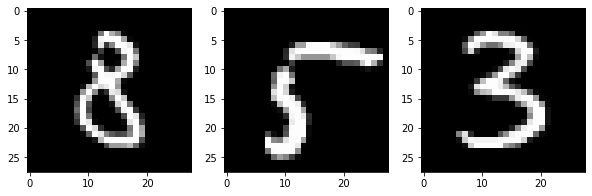

torch.Size([28, 28])


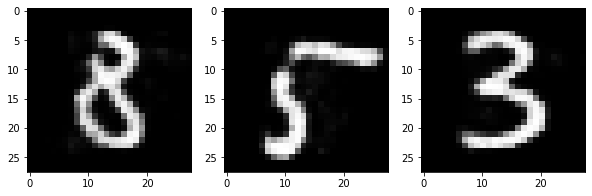

In [79]:
# visualize the aligner output
Imgs=[]
c=0
for (image, _) in loader:
  Imgs.append(image)
  c = c+1
  if(c==10):
    Img1 = Imgs[2]
    Img2 = Imgs[5]
    Img3 = Imgs[6]
    break

Imgss = torch.cat((Img1,Img2,Img3),1)
Imgsss = Imgss[2]
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
for i, image in enumerate(Imgsss):
    axs[i].imshow(image.squeeze(), cmap='gray')
plt.show()




model.cpu()
with torch.no_grad():
    pred = model(Img1,Img2,Img3)
pim1 = pred[2][0]
pim2 = pred[2][1]
pim3 = pred[2][2]
predimgs=[pim1,pim2,pim3]
print(pim1.shape)
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
for i, image in enumerate(predimgs):
    axs[i].imshow(image.squeeze(), cmap='gray')
plt.show()

In [80]:

#visualize classifier outputs
batch,labels = next(iter(loader))
digivect=model.Classifier(batch)

In [81]:
# Create a list of colors based on the labels
import matplotlib.colors as mcolors
# Generate a set of 10 distinct colors
colors = list(mcolors.TABLEAU_COLORS.values())
label_colors = [colors[labels % len(colors)] for labels in labels]

(64,)
torch.Size([64])


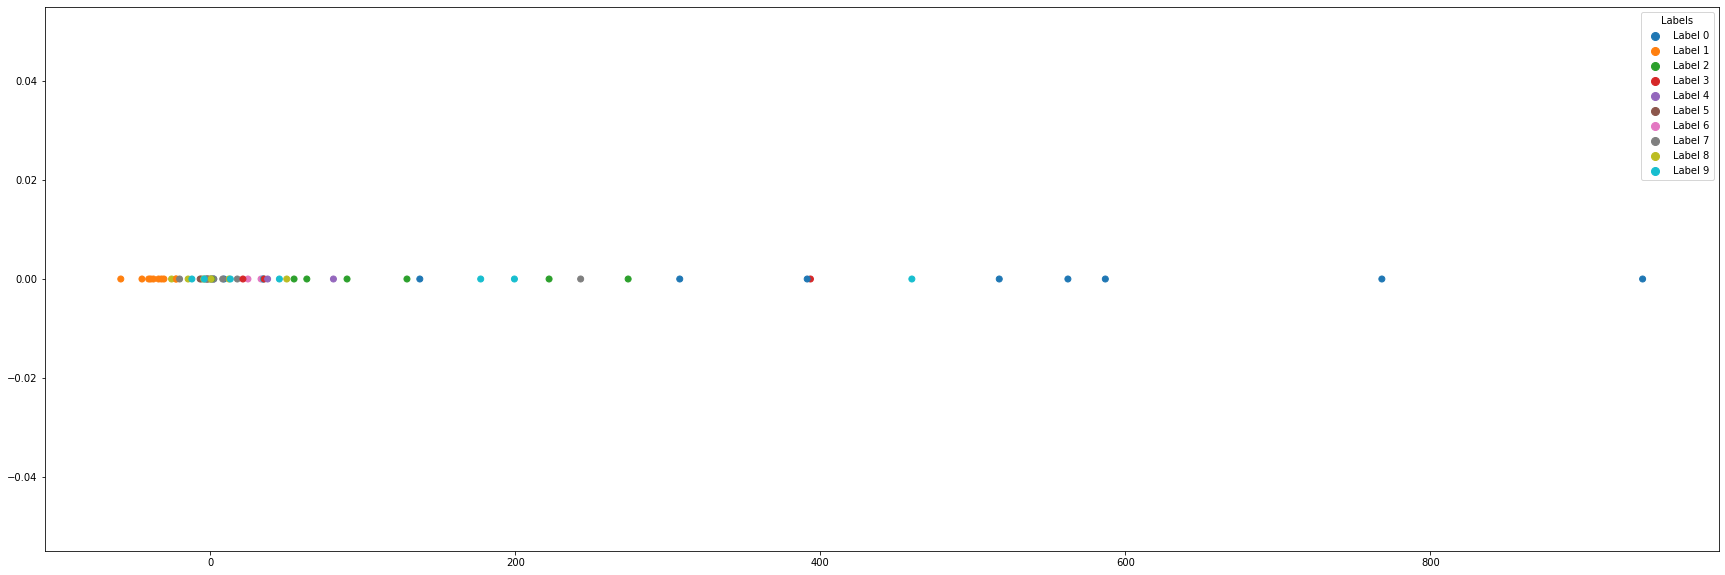

In [83]:
# Create a tensor of shape (64,2)


# Extract the x and y coordinates of the points
xx = digivect[:, 0]
yy = torch.zeros_like(xx)
xx = xx.detach().numpy()
print(xx.shape)
print(yy.shape)
# Create a scatter plot of the points
fig = plt.figure(figsize=(30, 10))
plt.scatter(xx, yy, c=label_colors)
handles = [plt.plot([],[], marker="o", ls="", color=color, markersize=8)[0] for color in colors]
labels = [f"Label {i}" for i in range(len(colors))]
plt.legend(handles, labels, loc="upper right", title="Labels")

# Show the plot
plt.show()
